In [1]:
sys.path.append('../jax_healpix/')
from SPHT_jax import *
from utils import *
from reshape_utils import *
from astropy.table import Table

In [2]:
nside=32
l_max=nside*3

In [3]:
npix=hp.nside2npix(nside)
pw=hp.pixwin(nside,lmax=l_max)
l_h, m_h = hp.Alm.getlm(lmax=l_max)

In [4]:
#https://stackoverflow.com/questions/69070804/how-to-reduce-jax-compile-time-when-using-for-loop

In [5]:
spins=(0,2)

In [6]:
#generate cl and healpy sims
pol=False
cl_inp=np.ones(nside*3)*1.e-2/(np.arange(nside*3)+1)
if 2 in spins:
    pol=True
    cl_inp=(cl_inp,cl_inp,cl_inp,cl_inp*0.1,cl_inp*0.1,cl_inp*0.1)

%time hmap=hp.synfast(cl_inp,nside=nside,new=True,pol=pol)


CPU times: user 603 ms, sys: 113 ms, total: 716 ms
Wall time: 11.5 ms


In [7]:
dict_keys=[0]
if pol:
    dict_keys=[0,2,-2]
labels_cl={0:'Spin-0'}
labels_cl[2]='Spin-2 E'
labels_cl[-2]='Spin-2 B'

labels_map={0:'Spin-0'}
labels_map[2]='Spin-2 Q'
labels_map[-2]='Spin-2 U'

In [8]:
# Gen maps in jax_healpix format (2-D grid)
hmap2,indxs=reshape_maps(nside,np.atleast_2d(hmap))
mask=stack_maps(nside,None) #this can be used to stack 2D shaped maps back into healpy format.
# hmap2=hmap2.at[:,:,1:].set(0)
# hmap=np.array(hmap2[:,mask][0])

if pol:
    hmap2={0:hmap2[:1,:,:],2:hmap2[1:2,:,:],-2:hmap2[2:,:,:]}
else:
    hmap2={0:hmap2}

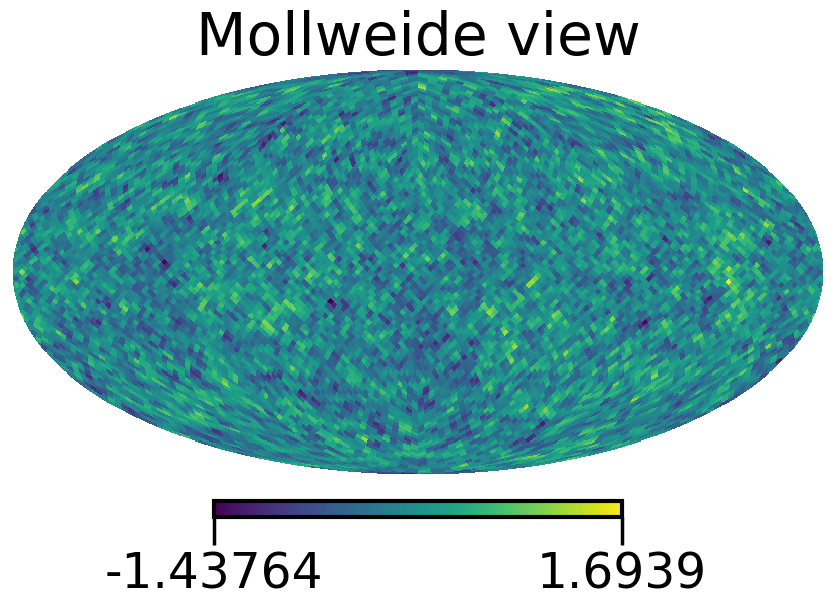

In [9]:
if pol:
    hp.mollview(hmap[0])
else:
    hp.mollview(hmap)

In [10]:
#alm and Cl from halpy
%time alm_hp=hp.map2alm(hmap,lmax=l_max,iter=0,pol=pol)
cl_hp=hp.anafast(hmap,lmax=l_max,use_weights=False,iter=0,pol=pol)
cl_hp=np.atleast_2d(cl_hp)
alm_hp=np.atleast_2d(alm_hp)

CPU times: user 2.53 s, sys: 27.8 ms, total: 2.56 s
Wall time: 20.3 ms


In [11]:
RING_ITER_SIZE #this is the number of ring simulatenously processed by jax_healpix. Total number of rings is 2X nside

256

In [12]:
#alm from hax_healpix
%time alm_t=map2alm(nside,l_max,spins,hmap2)

/home/deep/repos/SPHT/notebooks/../jax_healpix/SPHT_jax.py:67: RuntimeWarning: divide by zero encountered in log
  eq_beta = np.log(eq_beta)  # more accurate
/home/deep/repos/SPHT/notebooks/../jax_healpix/YLM_jax_log.py:58: RuntimeWarning: divide by zero encountered in log
  log_Alm = -1 * logdiffexp(2 * np.log(l), 2 * np.log(m))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:15: RuntimeWarning: divide by zero encountered in log
  log_diff = np.log(1 - np.exp(log_b - log_a))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:15: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(1 - np.exp(log_b - log_a))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:33: RuntimeWarning: invalid value encountered in subtract
  log_s = max_Arr + np.log1p(sign_s * np.exp(min_Arr - max_Arr))
/home/deep/repos/SPHT/notebooks/../jax_healpix/YLM_jax_log.py:105: RuntimeWarning: divide by zero encountered in log
  log_m = np.log(m)
/home/deep/repos/SPHT/notebooks/../jax_

CPU times: user 54.8 s, sys: 181 ms, total: 54.9 s
Wall time: 3.37 s


In [13]:
#Cl from jax_healpix. Only auto correlations here.
# cl_t=alm2cl(l_max, np.vstack((alm_t[s] for s in alm_t.keys())))
cl_t=alm2cl(l_max, np.vstack((alm_t[s] for s in dict_keys)))

/tmp/ipykernel_1591128/2121565723.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cl_t=alm2cl(l_max, np.vstack((alm_t[s] for s in dict_keys)))


In [14]:
#test closeness of Cl from two codes.
i=0
xx=np.isclose(cl_t[i],cl_hp[i])
labels_cl[dict_keys[i]],np.all(xx),cl_t[i][~xx]/cl_hp[i][~xx]

('Spin-0', True, array([], dtype=float64))

In [15]:
i=1
if pol:
    xx=np.isclose(cl_t[i],cl_hp[i])
labels_cl[dict_keys[i]],np.all(xx),cl_t[i][~xx]/cl_hp[i][~xx]

('Spin-2 E', True, array([], dtype=float64))

In [16]:
i=2
if pol:
    xx=np.isclose(cl_t[i],cl_hp[i])
labels_cl[dict_keys[i]],np.all(xx),cl_t[i][~xx]/cl_hp[i][~xx]

('Spin-2 B', True, array([], dtype=float64))

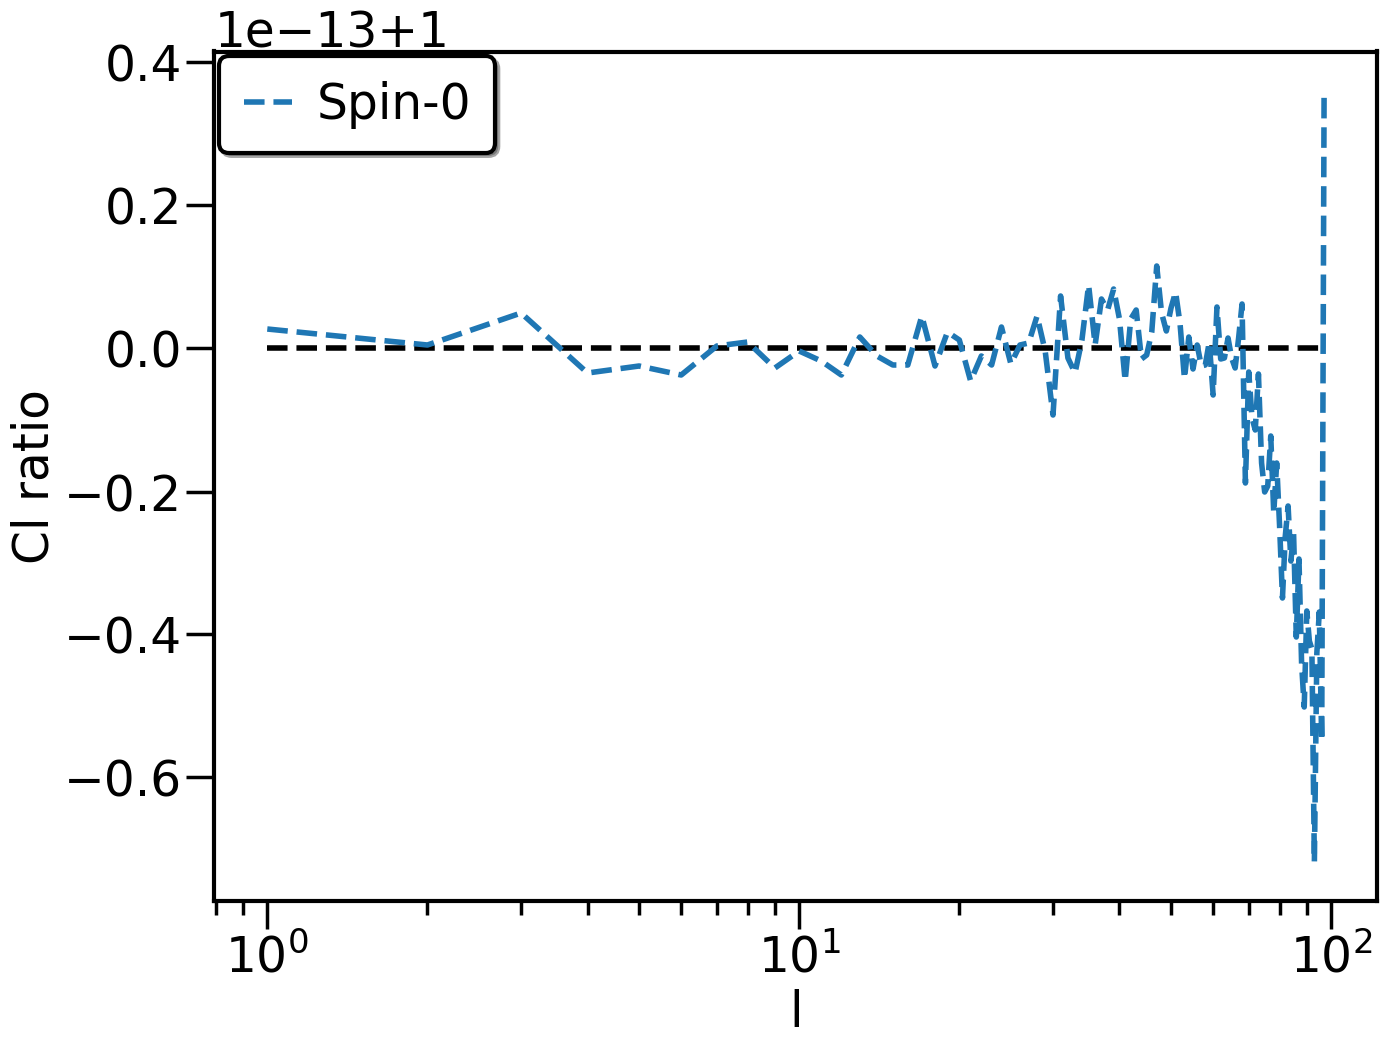

/tmp/ipykernel_1591128/1009556411.py:3: RuntimeWarning: invalid value encountered in true_divide
  plot(np.arange(l_max+1)+1,cl_t[i]/cl_hp[i],'--',label=labels_cl[dict_keys[i]])


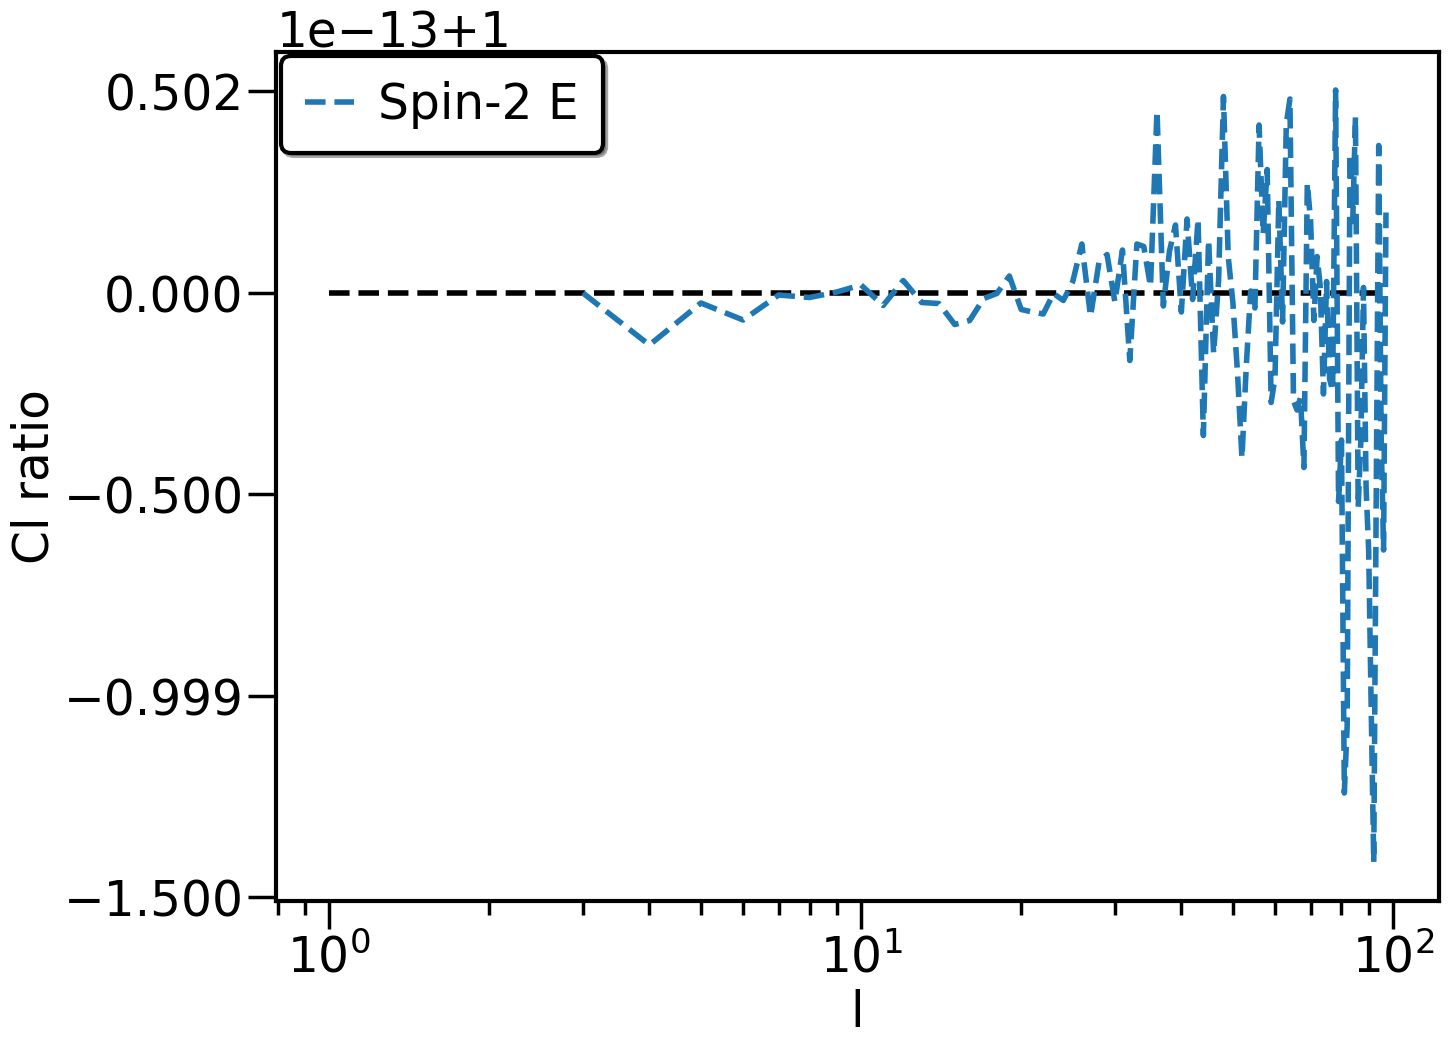

/tmp/ipykernel_1591128/1009556411.py:3: RuntimeWarning: invalid value encountered in true_divide
  plot(np.arange(l_max+1)+1,cl_t[i]/cl_hp[i],'--',label=labels_cl[dict_keys[i]])


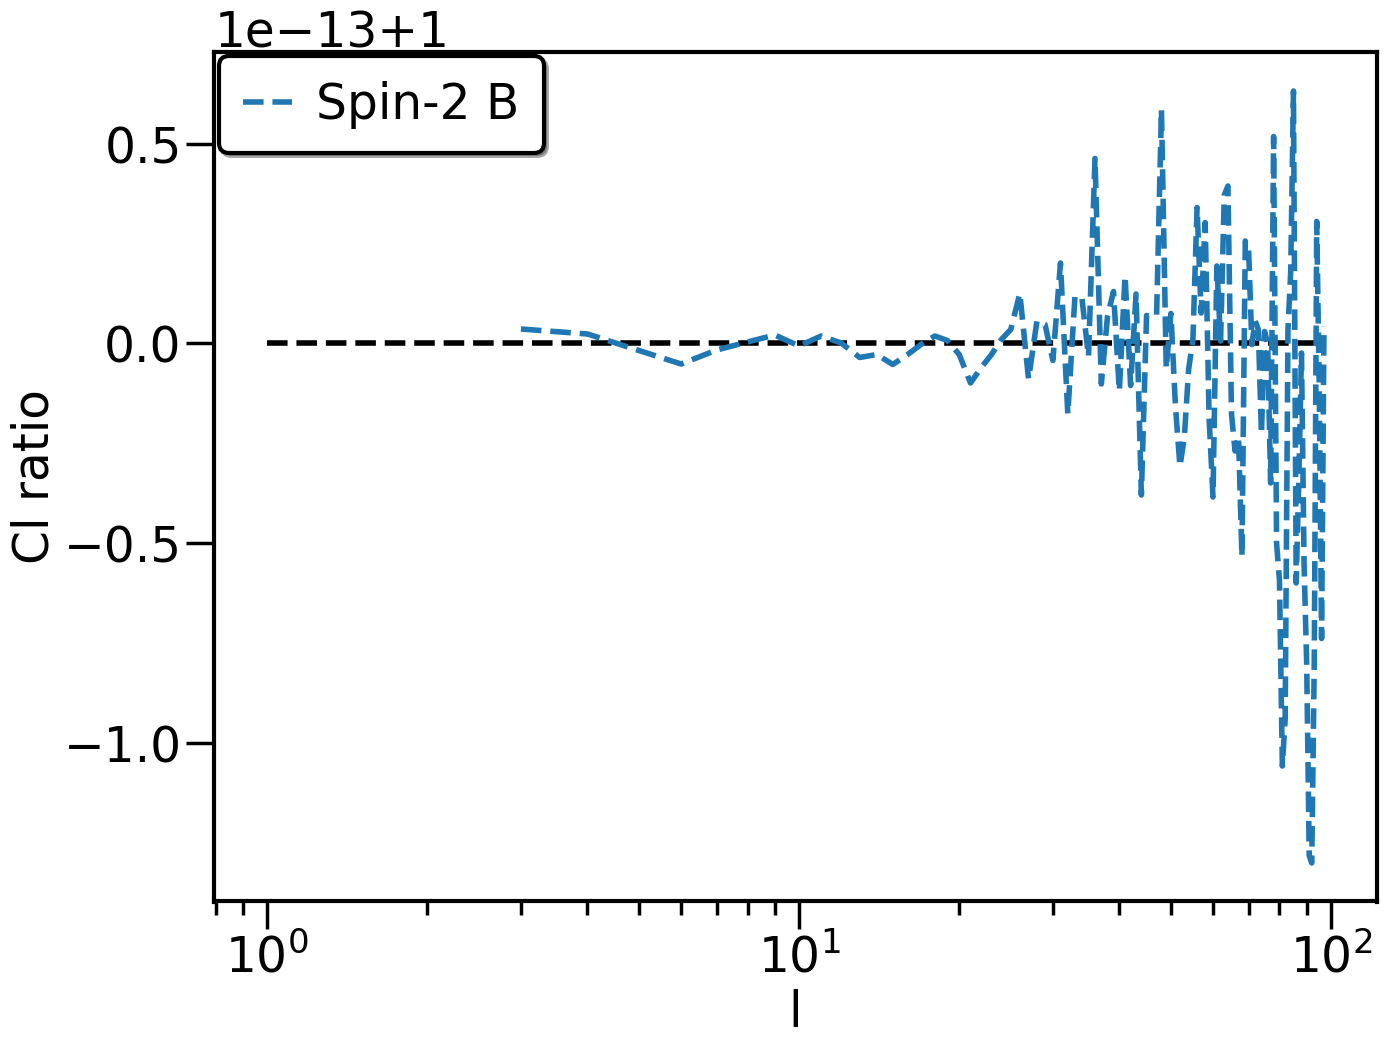

In [17]:
#plot ratios of Cl
for i in range(len(dict_keys)):
    plot(np.arange(l_max+1)+1,cl_t[i]/cl_hp[i],'--',label=labels_cl[dict_keys[i]])
    # plot(np.arange(l_max+1)+1,cl_t3/cl_hp3,'--')
    hlines(1,1,l_max+1,ls='--',color='k',zorder=-1)
    # vlines(nside,.9,1.1,color='k')
    xlabel('l')
    xscale('log')
    ylabel('Cl ratio')
    # ylim(1.e-1,10)
    # ylim(.9,1.1)
    legend()
    show()

In [18]:
for i in dict_keys:
    print(i,np.all(np.isfinite(alm_t[i])))

0 True
2 True
-2 True


In [19]:
#functions to stack 2D array of alm into 1D array of healpy format.
alm_t2=stack_alm(l_max,alm_t,order='m')
alm_t23=reshape_alm(l_max,alm_t2[0]) #reverse
np.all(alm_t23==alm_t[0])

True

In [20]:
#check closeness of real part of alms
for i in range(len(dict_keys)):
    s=dict_keys[i]
    xx=np.isclose(np.real(alm_t2[s][0]),np.real(alm_hp[i]),atol=1.e-4)
    r=np.real(alm_t2[s][0])[~xx]/np.real(alm_hp[i])[~xx]
    d=np.real(alm_t2[s][0])[~xx]-np.real(alm_hp[i])[~xx]
    print(s,np.all(xx),r,d,np.real(alm_hp[i])[~xx],np.real(alm_t2[s][0])[~xx])

0 True [] [] [] []
2 True [] [] [] []
-2 True [] [] [] []


In [21]:
#check closeness of imag part of alms
for i in range(len(dict_keys)):
    s=dict_keys[i]
    xx=np.isclose(np.imag(alm_t2[s][0]),np.imag(alm_hp[i]),atol=1.e-4)
    r=np.imag(alm_t2[s][0])[~xx]/np.imag(alm_hp[i])[~xx]
    d=np.imag(alm_t2[s][0])[~xx]-np.imag(alm_hp[i])[~xx]
    print(s,np.all(xx),r,d,np.imag(alm_hp[i])[~xx],np.imag(alm_t2[s][0])[~xx])

0 True [] [] [] []
2 True [] [] [] []
-2 True [] [] [] []


In [22]:
#reconstruct maps from alms, healpix
map_hp=hp.alm2map(alm_hp,nside,pol=pol)
# map_hp3=hp.alm2map(alm_hp3,nside,pol=False)

In [23]:
#reconstruct maps from alms, jax_healpix

%time map_t=alm2map(nside,l_max,(0,2),alm_t)
# map_t3=alm2map(nside,l_max,0,alm_t3)
# mm_i=alm2map(nside,l_max,0,alm_t_i)

/home/deep/repos/SPHT/notebooks/../jax_healpix/SPHT_jax.py:67: RuntimeWarning: divide by zero encountered in log
  eq_beta = np.log(eq_beta)  # more accurate
/home/deep/repos/SPHT/notebooks/../jax_healpix/YLM_jax_log.py:58: RuntimeWarning: divide by zero encountered in log
  log_Alm = -1 * logdiffexp(2 * np.log(l), 2 * np.log(m))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:15: RuntimeWarning: divide by zero encountered in log
  log_diff = np.log(1 - np.exp(log_b - log_a))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:15: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(1 - np.exp(log_b - log_a))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:33: RuntimeWarning: invalid value encountered in subtract
  log_s = max_Arr + np.log1p(sign_s * np.exp(min_Arr - max_Arr))
/home/deep/repos/SPHT/notebooks/../jax_healpix/YLM_jax_log.py:105: RuntimeWarning: divide by zero encountered in log
  log_m = np.log(m)
/home/deep/repos/SPHT/notebooks/../jax_

CPU times: user 54 s, sys: 52 ms, total: 54.1 s
Wall time: 3.62 s


In [24]:
#mask to stack maps in 2D format to 1D healpy format.
mask=stack_maps(nside,map_t[0])

In [25]:
tt=map_t[0][:,~mask]
np.all(tt==0)

True

In [26]:
map_t_s={}
for s in dict_keys:
    map_t_s[s]=map_t[s][:,mask]
# map_t3_s=map_t3[0][:,mask]
# mm2_i=mm_i[0][:,mask]

In [27]:
# compute errors in reconstructed maps
diff_map={}
i=0
for s in dict_keys:
    diff_map[s]=np.array(map_t_s[s][0]-hmap[i])
    i+=1

diff_map_hp=map_hp-hmap

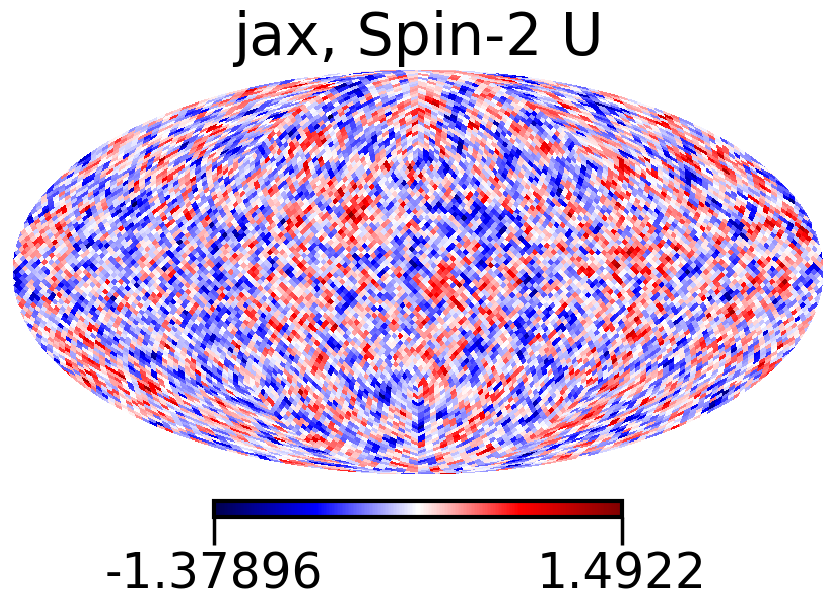

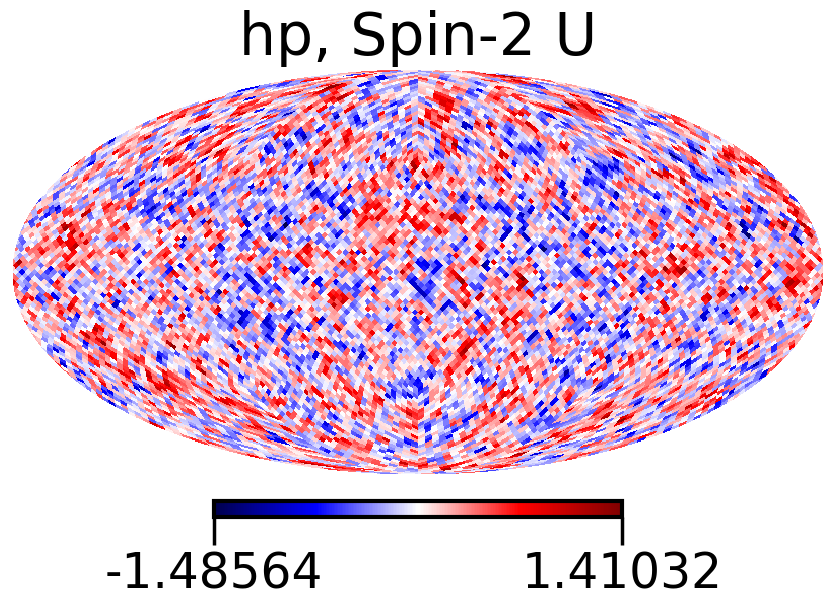

In [28]:
i=2
hp.mollview(np.imag(map_t_s[dict_keys[i]][0]),cmap='seismic',title='jax, '+labels_map[dict_keys[i]])#,min=-2,max=2)
hp.mollview(hmap[i],cmap='seismic',title='hp, '+labels_map[dict_keys[i]])#,min=-2,max=2)

/home/deep/.local/lib/python3.9/site-packages/healpy-1.15.0-py3.9-linux-x86_64.egg/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


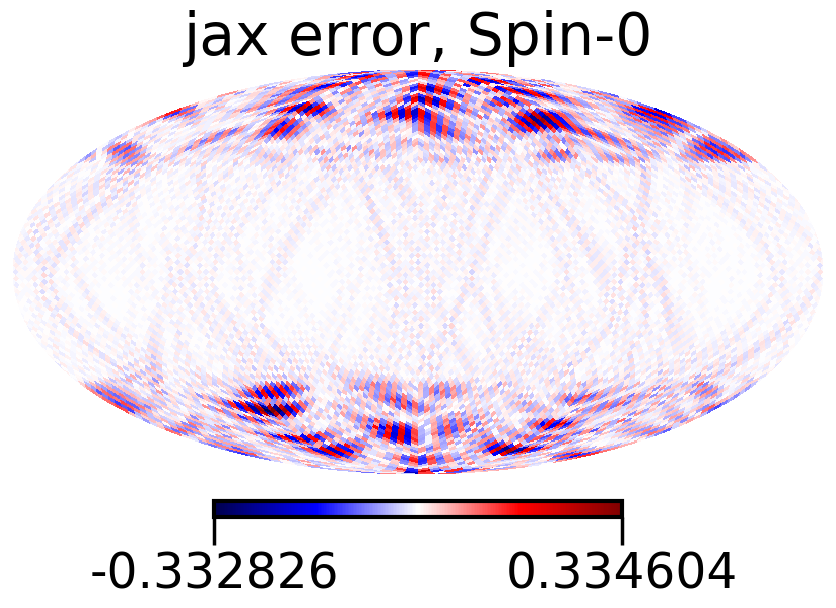

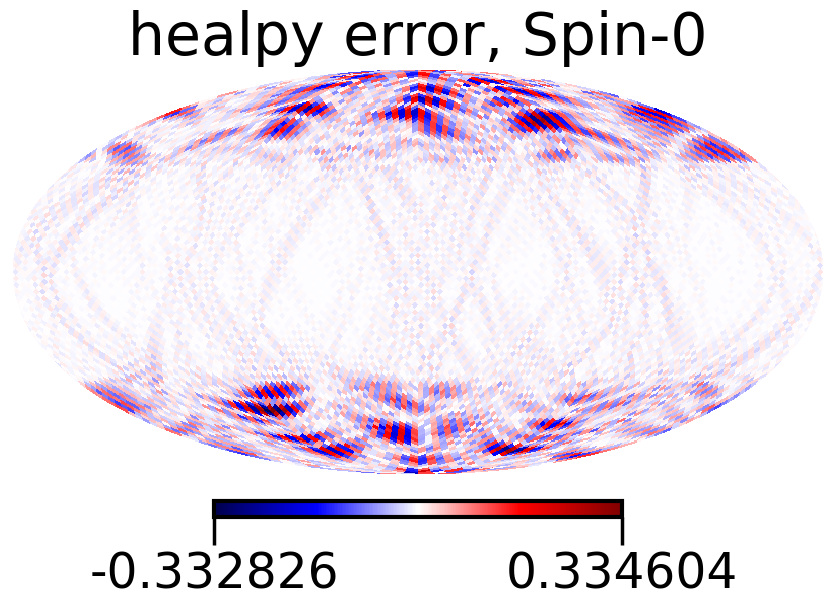

In [29]:
i=0
hp.mollview(diff_map[dict_keys[i]],cmap='seismic',title='jax error, '+labels_map[dict_keys[i]])#,min=-2,max=2)
hp.mollview(diff_map_hp[i],cmap='seismic',title='healpy error, '+labels_map[dict_keys[i]])#,min=-2,max=2)

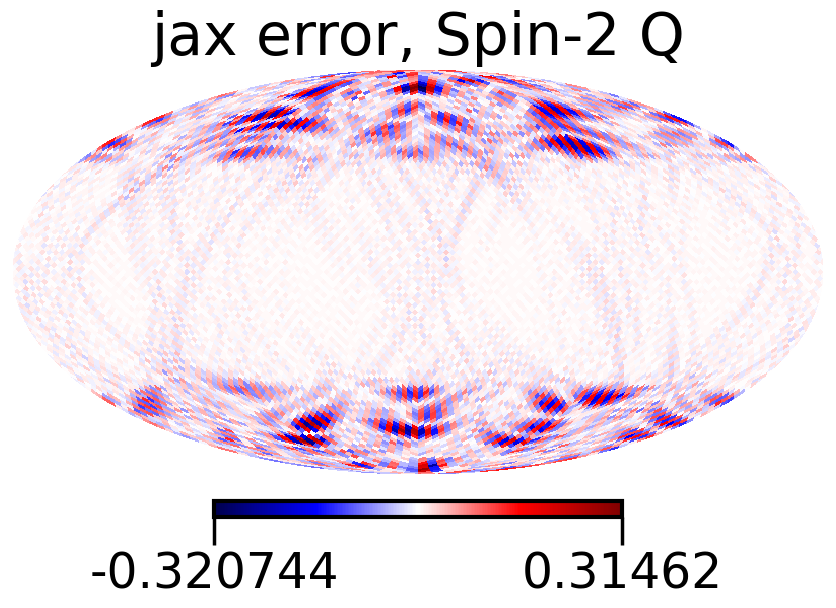

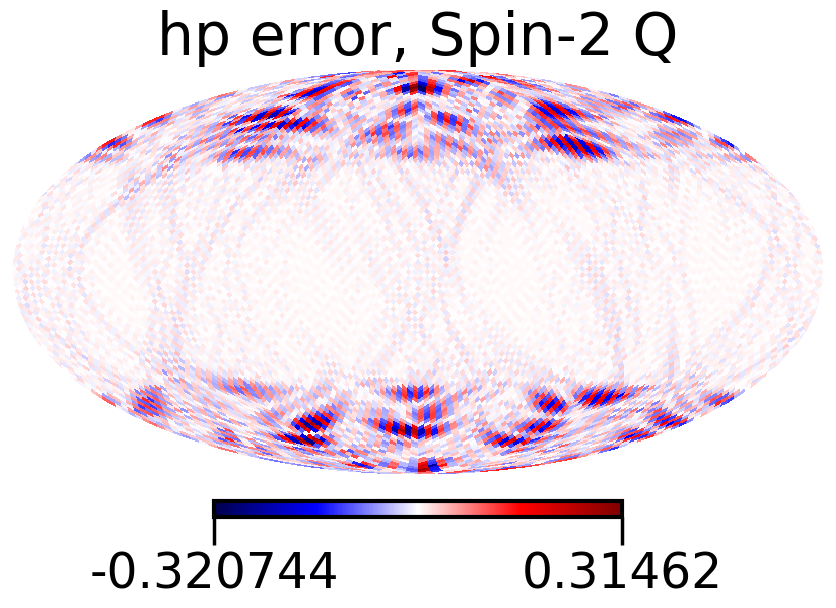

In [30]:
i=1
hp.mollview(diff_map[dict_keys[i]],cmap='seismic',title='jax error, '+labels_map[dict_keys[i]])#,min=-2,max=2)
hp.mollview(diff_map_hp[i],cmap='seismic',title='hp error, '+labels_map[dict_keys[i]])#,min=-2,max=2)

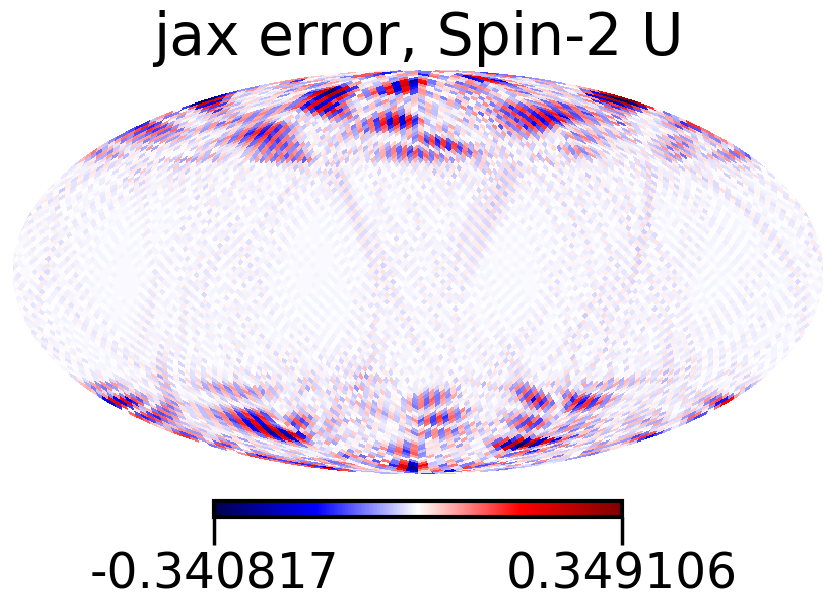

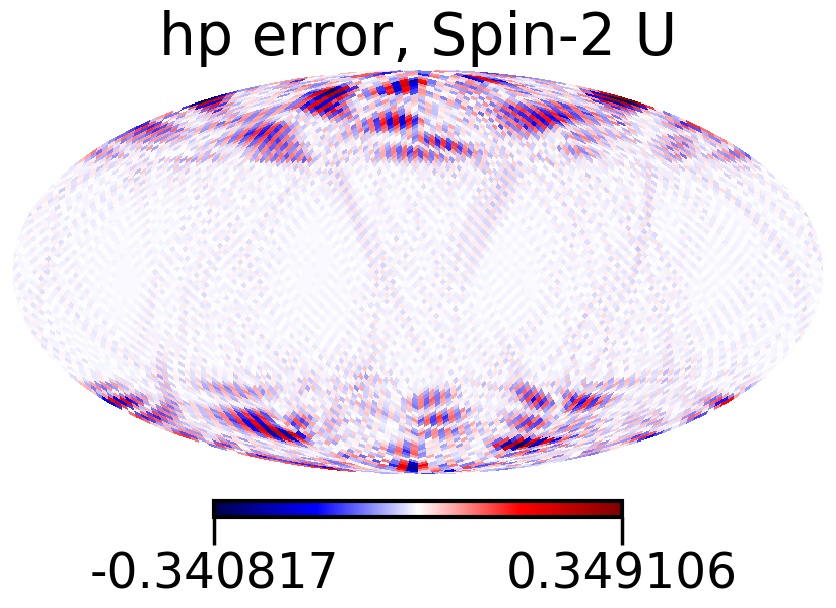

In [31]:
i=2
hp.mollview(diff_map[dict_keys[i]],cmap='seismic',title='jax error, '+labels_map[dict_keys[i]])#,min=-2,max=2)
hp.mollview(diff_map_hp[i],cmap='seismic',title='hp error, '+labels_map[dict_keys[i]])#,min=-2,max=2)

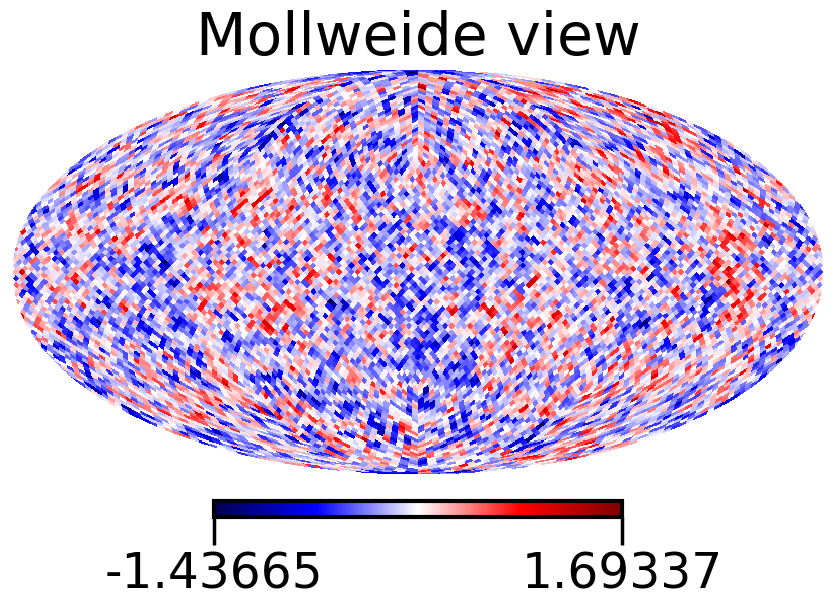

In [32]:
hp.mollview(map_t_s[0][0],cmap='seismic')

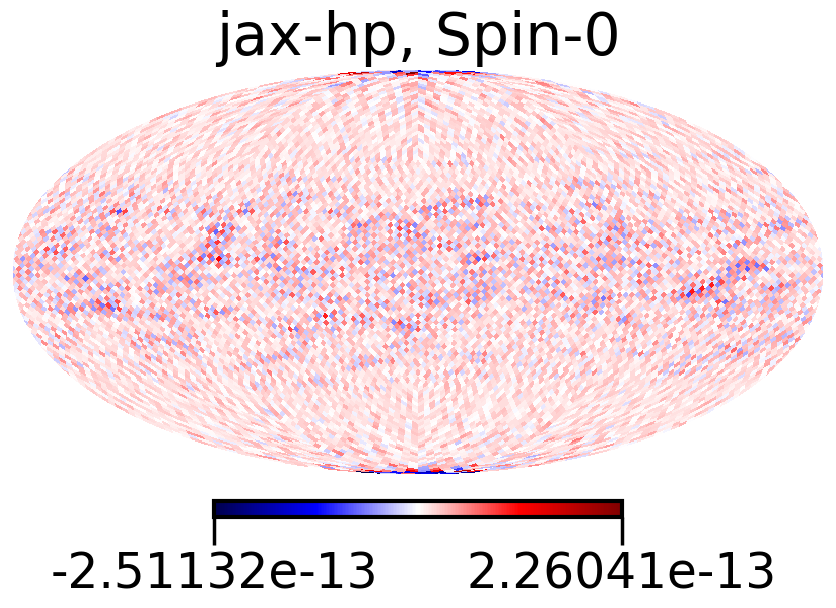

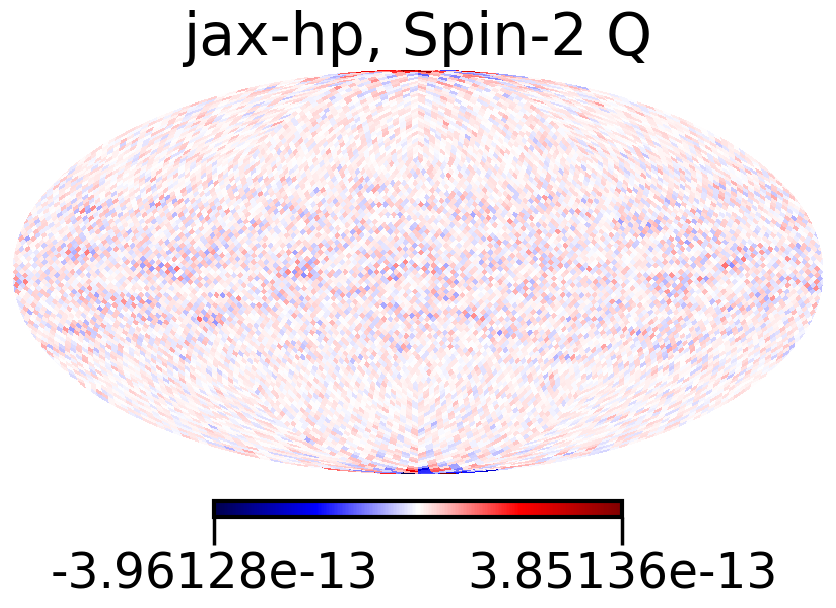

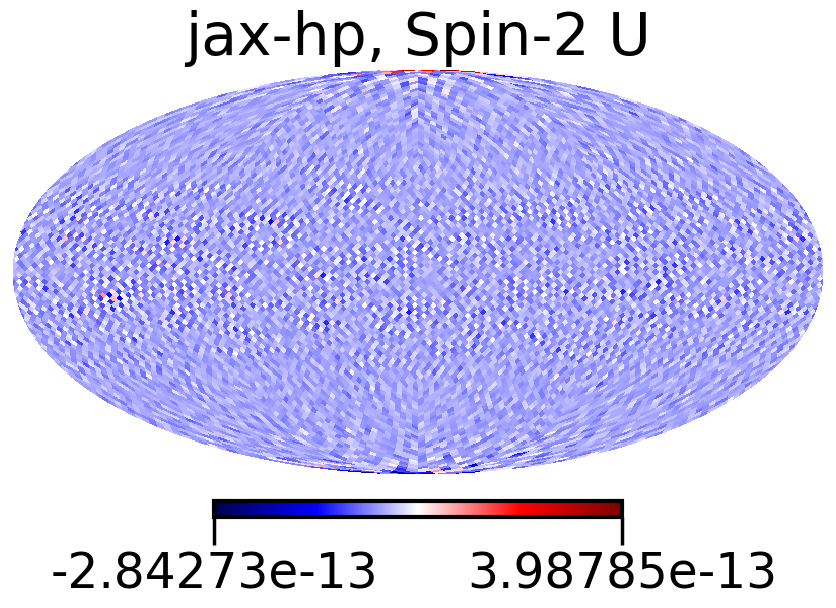

In [33]:
i=0
for s in dict_keys:
    hp.mollview(map_t_s[s][0]-map_hp[i],title='jax-hp, '+labels_map[s],cmap='seismic')
    i+=1
    show()

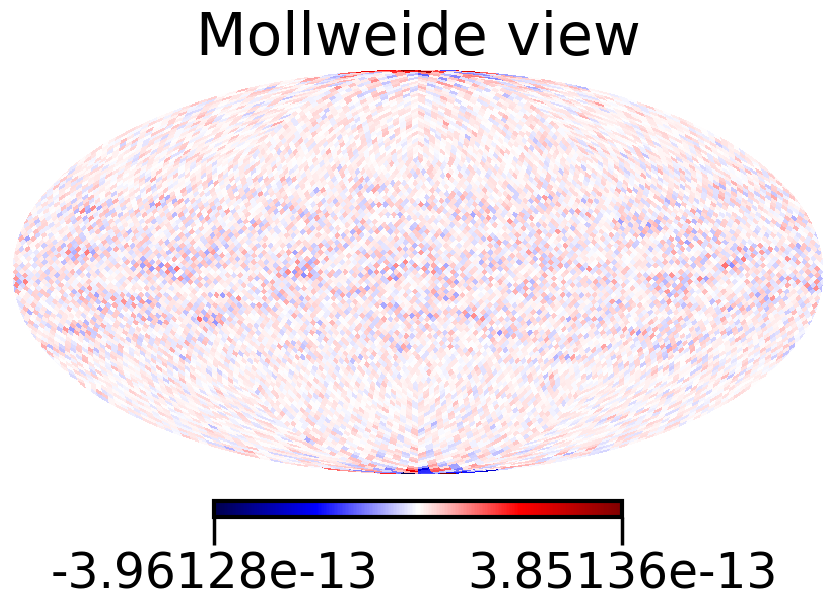

In [34]:
hp.mollview(map_t_s[2][0]-map_hp[1],cmap='seismic')

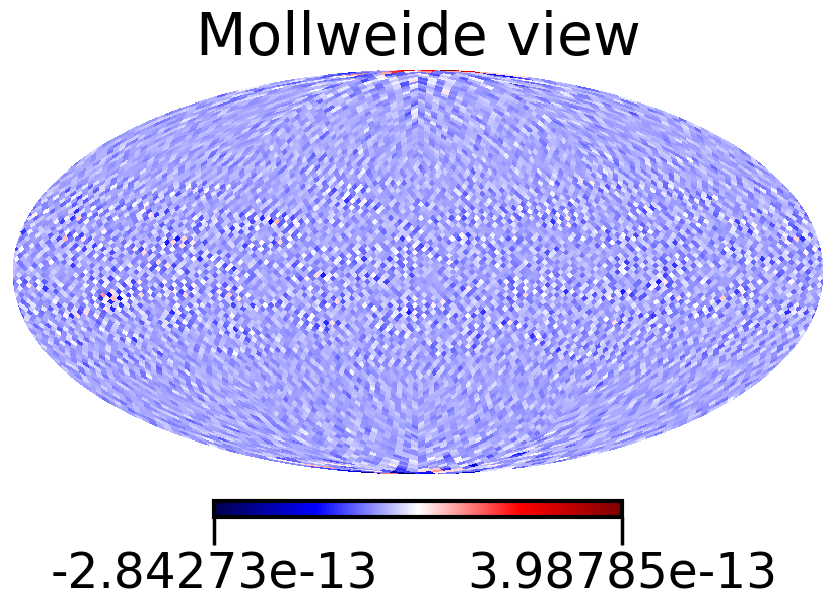

In [35]:
hp.mollview(map_t_s[-2][0]-map_hp[2],cmap='seismic')

In [36]:
cl_jax_hp_cross={}
cl_hp_hp_cross={}
cl_diff_jax={}
cl_diff_hp={}

In [37]:
i=0
for s in dict_keys: #FIXME: does not account for polarization
    cl_jax_hp_cross[s]=hp.anafast(np.array(map_t_s[s][0]),hmap[i],lmax=l_max)    
    cl_hp_hp_cross[s]=hp.anafast(np.array(map_hp[i]),hmap[i],lmax=l_max)    
    i+=1
cl_diff_jax=hp.anafast(np.vstack((diff_map[s] for s in dict_keys)),lmax=l_max,pol=pol,iter=0)    

/home/deep/.local/lib/python3.9/site-packages/healpy-1.15.0-py3.9-linux-x86_64.egg/healpy/sphtfunc.py:268: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(
/tmp/ipykernel_1591128/2447882640.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cl_diff_jax=hp.anafast(np.vstack((diff_map[s] for s in dict_keys)),lmax=l_max,pol=pol,iter=0)


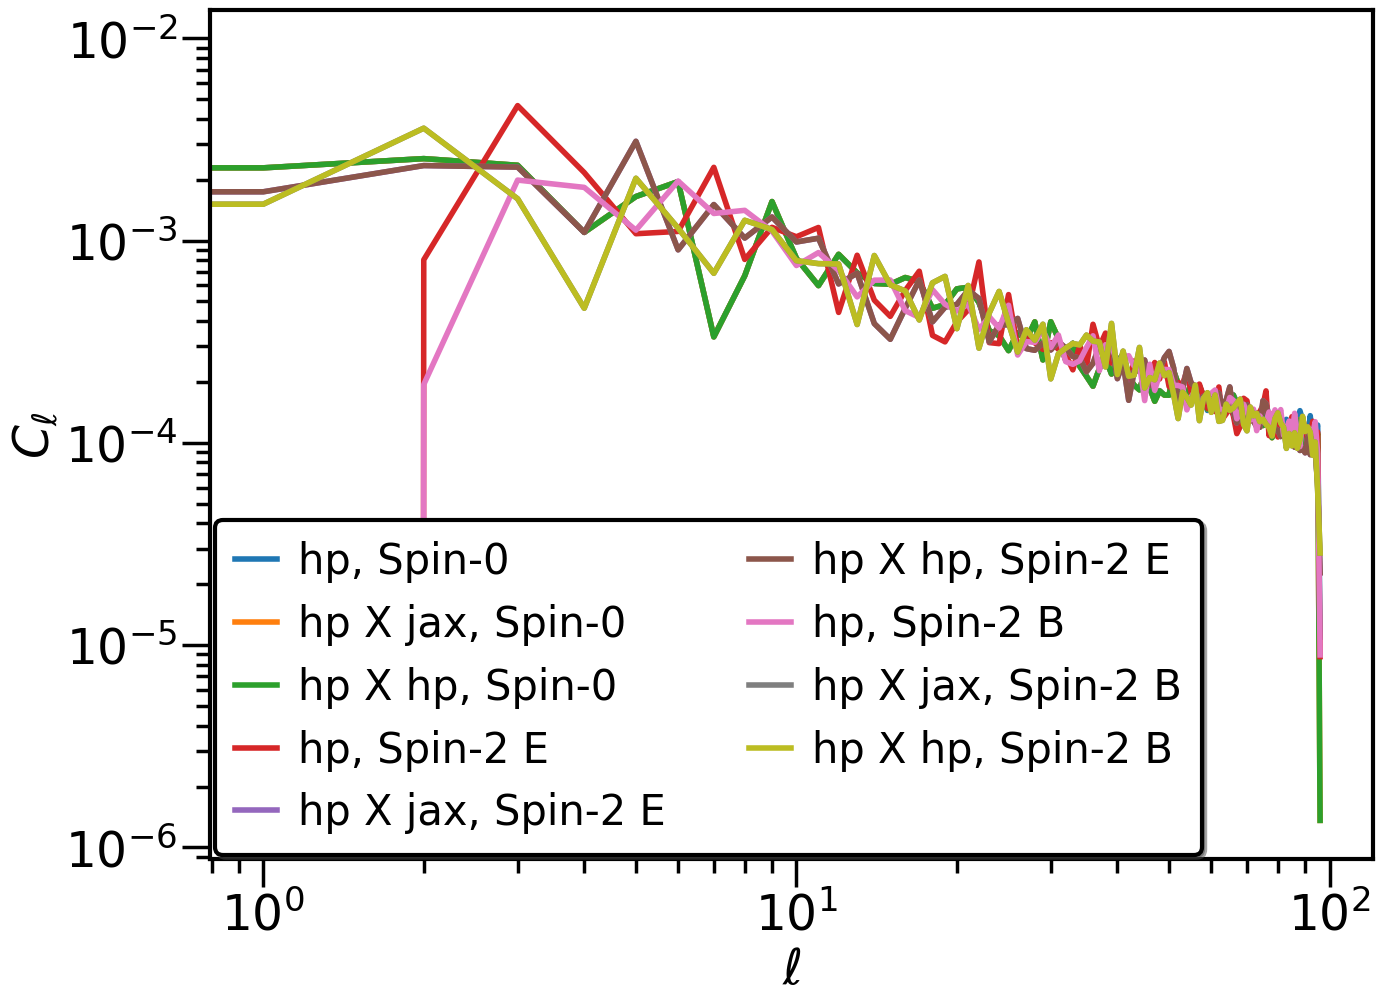

In [38]:
i=0
for s in dict_keys:
    plot(cl_hp[i],label='hp, '+labels_cl[dict_keys[i]])
    plot(cl_jax_hp_cross[s],label='hp X jax, '+labels_cl[dict_keys[i]])
    plot(cl_hp_hp_cross[s],label='hp X hp, '+labels_cl[dict_keys[i]])
    loglog()
    # ylim(1.e-9,1.e-5)
    # ylim(1.e-1,2)
    xlabel(r"$\ell$")
    ylabel(r"$C_\ell$")
    i+=1
legend(fontsize=30,ncol=2,loc='lower left')

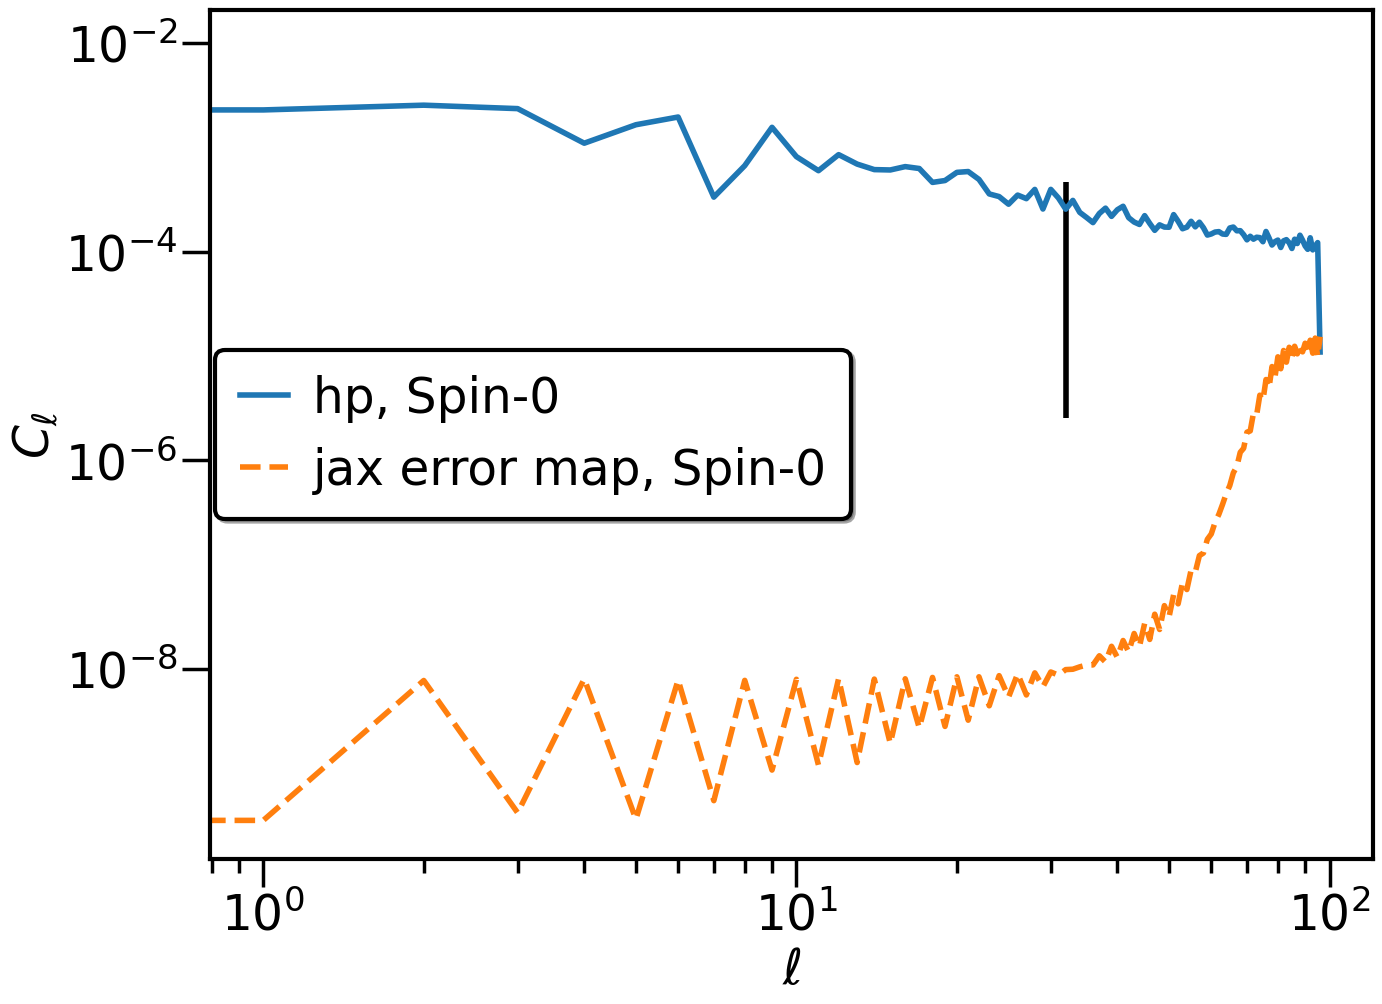

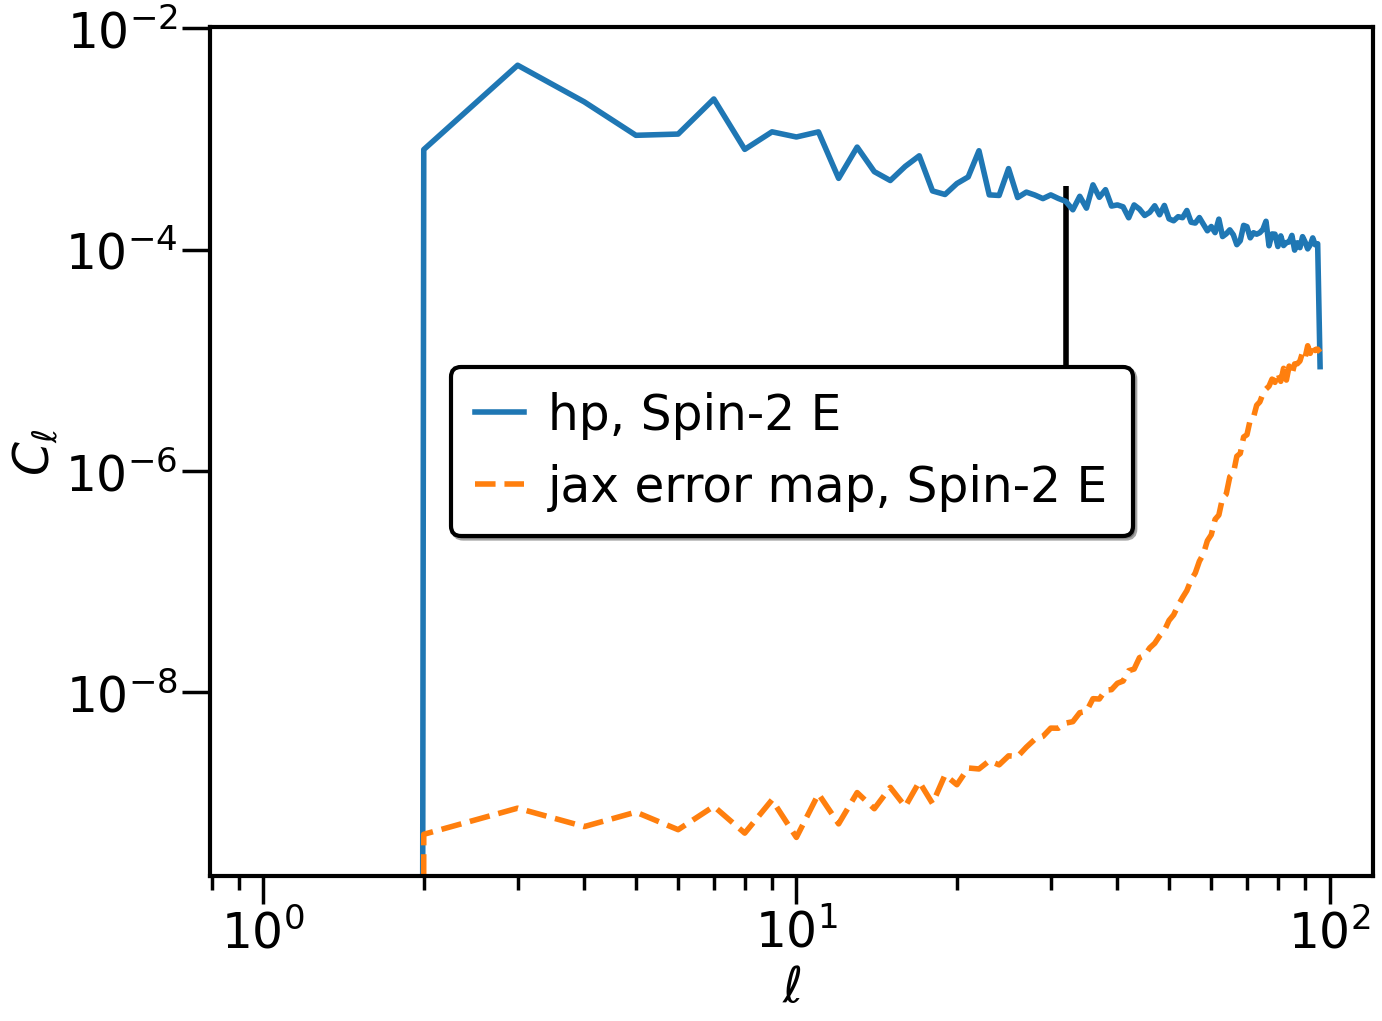

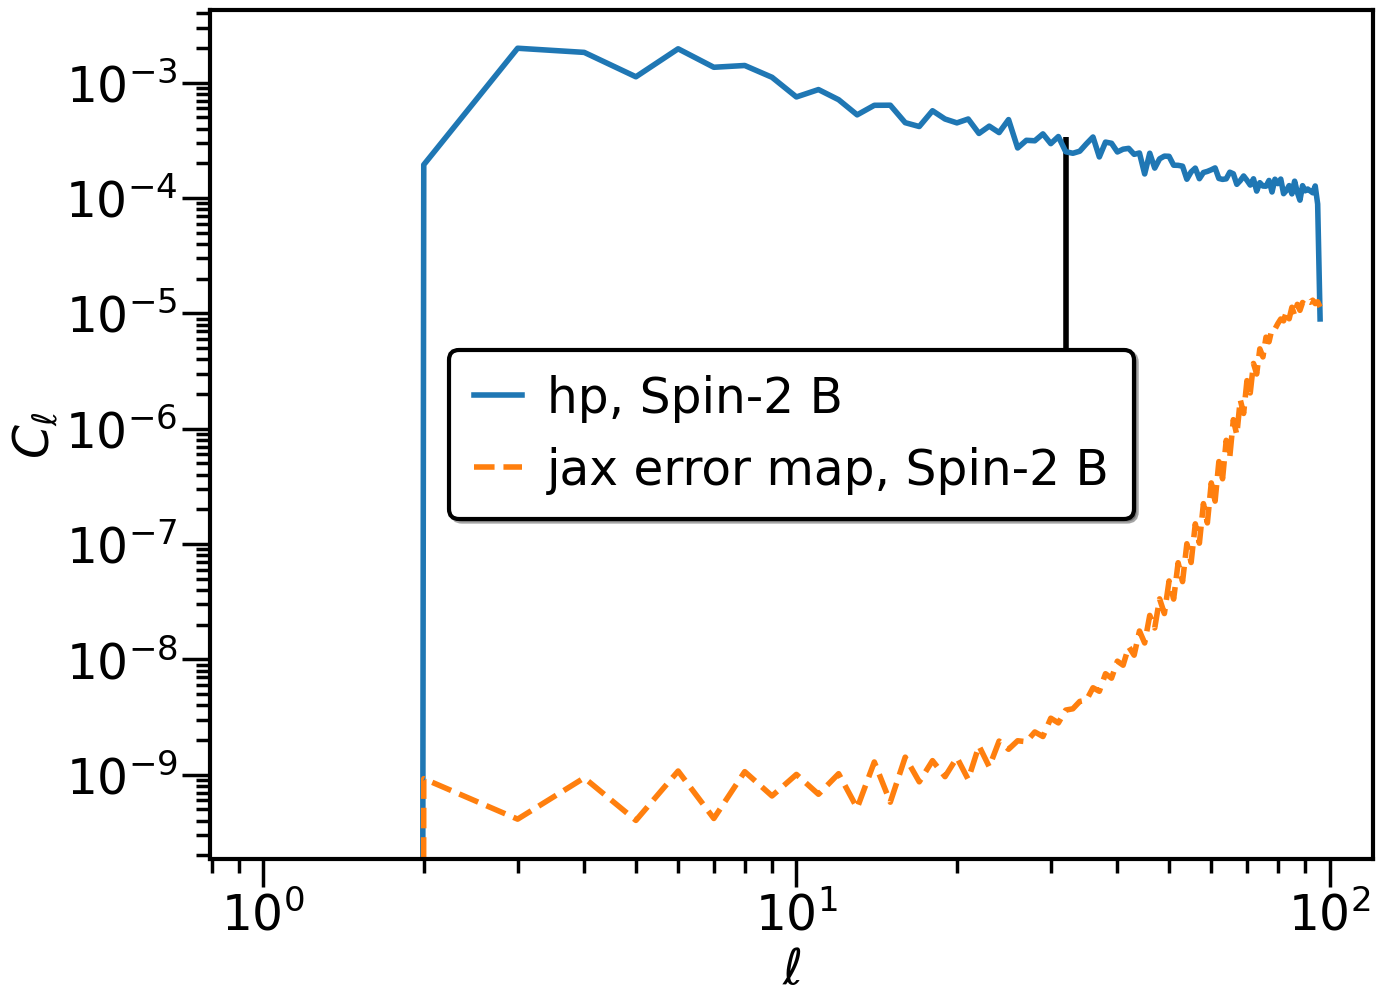

In [39]:
i=0
for s in dict_keys:
    plot(cl_hp[i],label='hp, '+labels_cl[dict_keys[i]])
    plot(cl_diff_jax[i],'--',label='jax error map, '+labels_cl[dict_keys[i]])
    vlines(nside,cl_diff_jax[i][:100].mean(),cl_hp[i].mean(),color='k')
#     vlines(256,cl_diff_jax[i][:100].mean(),cl_hp[i].mean(),color='k')
    # plot(cl_dm2*-1,':')
    loglog()
    i+=1
    legend()
    xlabel(r"$\ell$")
    ylabel(r"$C_\ell$")
    show()